# **Business Case**

Retinopathy is a progressive condition that damages the retina, the light-sensitive layer at the back of the eye, and can lead to partial or complete blindness if not identified early. The disease is strongly associated with systemic conditions such as diabetes and high blood pressure, which are increasingly common in today’s population. Early detection of retinopathy is therefore essential for preventing severe vision loss and enabling timely treatment.  
Traditional diagnosis methods rely heavily on ophthalmologists manually examining retina images, which is both time-consuming and prone to human error, especially in large-scale screenings. With the advancement of artificial intelligence, computer vision models can now assist in identifying early signs of retinopathy from retinal scans.  
This project was designed to create a deep learning model that can automatically classify retina images into specific categories of retinopathy. By automating this process, the model can provide doctors with an effective decision-support system, speed up the screening process, and ensure that patients at risk are prioritized for medical attention.

# **Domain Analysis**

The healthcare domain, and medical imaging in particular, presents unique challenges for applying AI models due to the high stakes of misclassification. Retinal disease detection requires models that are not only accurate but also reliable across all classes of disease severity. In this project, the dataset consists of retina scan images and a CSV file that maps each image to a diagnostic category, encoded as numerical values.  
The presence of three diagnostic categories makes this a **multi-class classification problem**. However, a major challenge encountered was data imbalance, where one class had significantly more samples than the others. Such imbalance can bias the model toward predicting the majority class while neglecting the minority ones, which is highly undesirable in a medical context. Various strategies were explored to handle this issue, and after experimentation, upsampling of the minority classes was applied.  
While synthetic data generation in medical imaging should be used cautiously, in this case, upsampling was necessary to balance the dataset and allow the model to learn fairly across all categories. The project also experimented with both custom CNN architectures and pretrained models such as EfficientNet, providing insights into their suitability for medical image classification tasks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/AI projects/Client project/ratinopathy.zip"
extract_path = os.path.dirname(zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed successfully!")


Extraction completed successfully!


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
CSV_PATH = "/content/drive/MyDrive/AI projects/Client project/data_all.csv"
IMG_DIR = "/content/drive/MyDrive/AI projects/Client project/images"

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI projects/Client project/data_all.csv")

Original class distribution:
cat
1    811
2    569
3    384
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Index   1764 non-null   int64 
 1   file    1764 non-null   object
 2   cat     1764 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.5+ KB


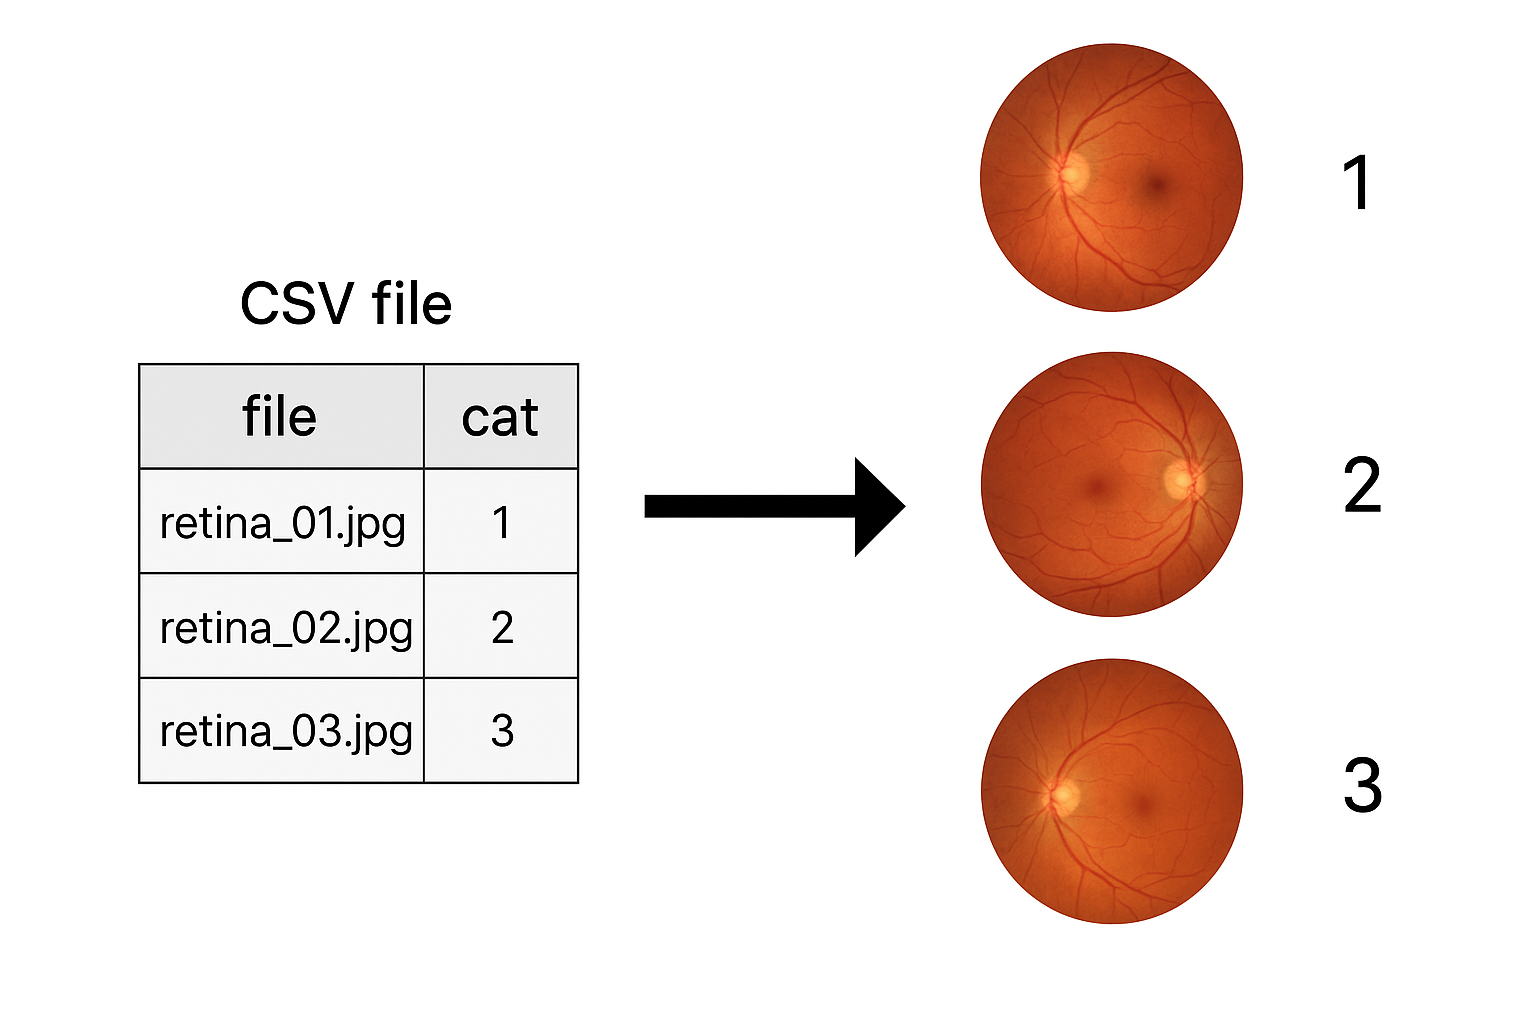

In [ ]:
df.rename(columns={'Unnamed: 0':'Index'}, inplace=True)
df['cat'] = df['cat'] - 1
df['cat'] = df['cat'].astype(str)

In [ ]:
print("Original class distribution:")
print(df["cat"].value_counts())

Original class distribution:
cat
0    811
1    569
2    384
Name: count, dtype: int64


In [ ]:
dfs = []
max_size = df["cat"].value_counts().max()

for class_id in df["cat"].unique():
    df_class = df[df["cat"] == class_id]
    df_class_over = resample(df_class,
                             replace=True,
                             n_samples=max_size,
                             random_state=42)
    dfs.append(df_class_over)


df_balanced = pd.concat(dfs)

print("\nBalanced class distribution:")
print(df_balanced["cat"].value_counts())



Balanced class distribution:
cat
0    811
1    811
2    811
Name: count, dtype: int64


In medical imaging tasks, handling imbalanced datasets requires special care because artificially adding or altering samples can sometimes introduce noise or misleading patterns, leading to **false predictions**. Ideally, medical datasets should be expanded with genuine, high-quality data rather than synthetic **balancing**. However, in this specific project, multiple approaches were tested, and since none provided satisfactory improvement, we resorted to **upsampling the minority classes**. This step was necessary to balance the dataset and allow the model to learn more effectively across all categories.


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["cat"],
    random_state=42
)


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file",
    y_col="cat",
    directory=img_dir,
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="file",
    y_col="cat",
    directory=img_dir,
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 1946 validated image filenames belonging to 3 classes.
Found 487 validated image filenames belonging to 3 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')   # 3 classes
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    ]
)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.4889 - loss: 1.0627 - val_accuracy: 0.6509 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.5908 - loss: 0.7326 - val_accuracy: 0.5996 - val_loss: 0.7328 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.6215 - loss: 0.7125 - val_accuracy: 0.6489 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - accuracy: 0.6375 - loss: 0.6939 - val_accuracy: 0.6756 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.6672 - loss: 0.6643 - val_accuracy: 0.6920 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.7068 - loss: 0.6174 - val_accuracy: 0.7228 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.7298 - loss: 0.

In [ ]:
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_gen.class_indices.keys())))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       162
           1       0.74      0.70      0.72       162
           2       0.72      0.72      0.72       163

    accuracy                           0.80       487
   macro avg       0.79      0.80      0.80       487
weighted avg       0.79      0.80      0.80       487



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])


model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    ]
)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 68s 787ms/step - accuracy: 0.3278 - loss: 1.1479 - val_accuracy: 0.3326 - val_loss: 1.0988 - learning_rate: 0.0010
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.3143 - loss: 1.1017 - val_accuracy: 0.3326 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.3391 - loss: 1.0986 - val_accuracy: 0.3326 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.3236 - loss: 1.0987 - val_accuracy: 0.3326 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.3381 - loss: 1.0990
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.3380 - loss: 1.0990 - val_accuracy: 0.3326 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.3347 - loss: 1.09

In [ ]:
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 651ms/step
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       162
           1       0.00      0.00      0.00       162
           2       0.00      0.00      0.00       163

    accuracy                           0.33       487
   macro avg       0.11      0.33      0.17       487
weighted avg       0.11      0.33      0.17       487



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


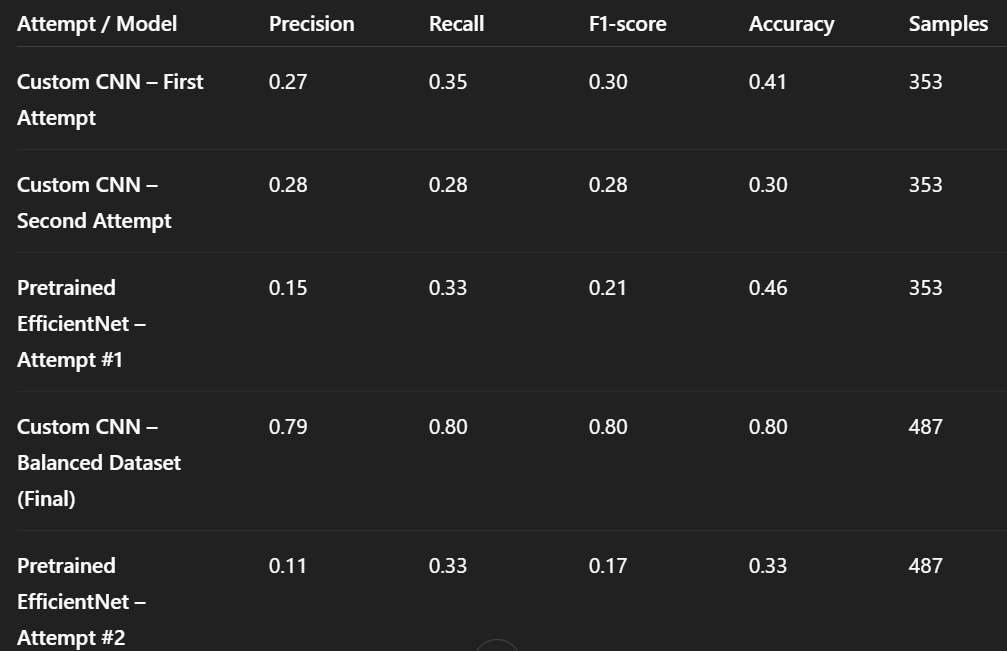

The first three entries in the table correspond to models trained on the **imbalanced dataset**, which resulted in poor and inconsistent performance (accuracy between **30–46%**). These initial attempts, including two custom CNNs and one EfficientNet run, were later removed from this main code file.  
In contrast, the **Custom CNN with balanced data** achieved the best results, with **80% accuracy** and well-distributed precision, recall, and F1-scores across all classes, clearly outperforming the pretrained EfficientNet attempts.


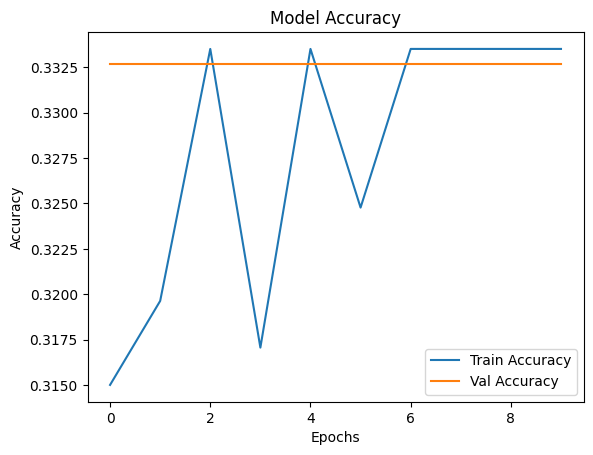

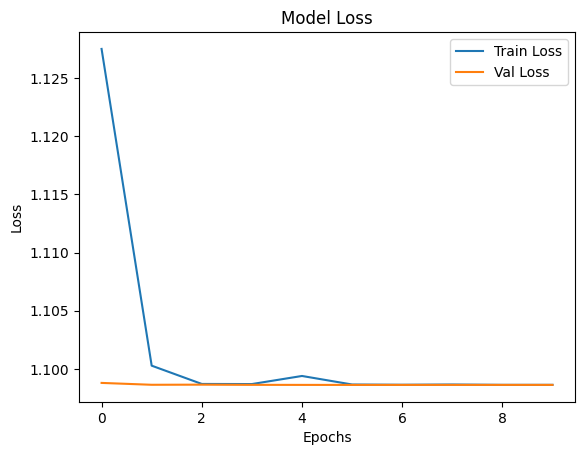

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/drive/MyDrive/AI projects/Client project/images/o_c2t192246700.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = np.expand_dims(np.array(img)/255.0, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class: 0


Predicted Class: 0 this means that the image belongs to first category of images

# **Conclusion**

This project demonstrates the practical application of deep learning in medical image classification, specifically for detecting types of retinopathy. The results showed that while pretrained models like EfficientNet were tested, the custom CNN architecture performed best for this dataset, achieving strong precision, recall, and F1-scores across all classes.  
Balancing the dataset through upsampling was a key step in ensuring the model could generalize well to minority classes and not just the majority category. Although this approach provided a significant performance boost, it also highlighted the limitations of working with small and imbalanced medical datasets, where acquiring real, high-quality data would be ideal.  
The project’s outcomes underline the potential of AI as a supportive tool in healthcare, capable of assisting medical professionals by speeding up screening processes and reducing manual workload. Ultimately, this project lays the groundwork for building scalable and reliable AI solutions in the medical imaging domain, contributing toward more accessible and accurate disease detection.